<a href="https://colab.research.google.com/github/ochavilloj/Global-Drinking-Habit-Analysis/blob/master/Linear_Regression_Solving_the_Normal_Equations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 4: Numerical methods for solving the normal equations

## Imports

In [1]:
# Import pandas, numpy, and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# seaborn is a data visualization library built on matplotlib
import seaborn as sns
# set the plotting style
sns.set_style("whitegrid")

# Train-test splits
from sklearn.model_selection import train_test_split

#Model preprocessing
from sklearn import preprocessing

# Linear regression models
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Model metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Linear algebra
from scipy import linalg

In [2]:
0.3 - 0.1

0.19999999999999998

## Load the data

##### $\rightarrow$ Load the `EdGap` data set.

In [3]:
df = pd.read_excel('https://raw.githubusercontent.com/brian-fischer/DATA-5100/main/EdGap_data.xlsx', dtype={'NCESSCH School ID':object})

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


##### $\rightarrow$ Explore the data set.

In [4]:
df.head()

,NCESSCH School ID,CT Unemployment Rate,CT Pct Adults with College Degree,CT Pct Childre In Married Couple Family,CT Median Household Income,School ACT average (or equivalent if SAT score),School Pct Free and Reduced Lunch
0,100001600143,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901
1,100008000024,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412
2,100008000225,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816
3,100017000029,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960
4,100018000040,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641


##### $\rightarrow$ Rename the columns.

In [5]:
df = df.rename(columns={"NCESSCH School ID":"id",
              "CT Pct Adults with College Degree":"percent_college",
              "CT Unemployment Rate":"rate_unemployment",
              "CT Pct Childre In Married Couple Family":"percent_married",
              "CT Median Household Income":"median_income",
              "School ACT average (or equivalent if SAT score)":"average_act",
              "School Pct Free and Reduced Lunch":"percent_lunch"})

In [6]:
df.head()

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch
0,100001600143,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901
1,100008000024,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412
2,100008000225,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816
3,100017000029,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960
4,100018000040,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641


## Quick data cleaning

##### $\rightarrow$ Check the range of each variable.

In [7]:
df.agg(['min','max'])

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch
min,100001600143,0.000000,0.091493,0.0,3589.0,-3.070818,-0.054545
max,560583000335,0.590278,1.000000,1.0,226181.0,32.362637,0.998729


##### $\rightarrow$ Set out-of-range values to `NaN`.

In [8]:
df.loc[df['average_act'] < 1, 'average_act'] = np.nan

In [9]:
df.loc[df['percent_lunch'] < 0, 'percent_lunch'] = np.nan

##### $\rightarrow$ Find and replace `NaN` values of **input variables** with the mode of each column.

In [10]:
df.isna().sum()

,0
id,0
rate_unemployment,14
percent_college,13
percent_married,25
median_income,20
average_act,3
percent_lunch,20


In [11]:
input_modes = df[df.columns.difference(['id','average_act'])].mode().iloc[0]

In [12]:
df = df.fillna(input_modes)

In [13]:
df.isna().sum()

,0
id,0
rate_unemployment,0
percent_college,0
percent_married,0
median_income,0
average_act,3
percent_lunch,0


##### $\rightarrow$ Drop columns where the output variable `average_act` is `NaN`.

In [14]:
df = df.dropna()

In [15]:
df.isna().sum()

,0
id,0
rate_unemployment,0
percent_college,0
percent_married,0
median_income,0
average_act,0
percent_lunch,0


## Train test split

##### $\rightarrow$ Define the matrix of predictor variables `X` to be all columns except `id` and `average_act` and define the output variable `y` to be `average_act`.

In [16]:
X = df[df.columns.difference(['id','average_act'])]
y = df['average_act']

##### $\rightarrow$ Split the data into training and testing sets. Keep 20% of the data for the test set.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 10)

##### $\rightarrow$ Scale the predictor variables in the training set to have mean 0 and standard deviation 1.

Define the scaler using only the training data. For the validation set approach to work, we can not incorporate any knowledge of the validation set's properties into the model building process.

In [18]:
scaler = preprocessing.StandardScaler().fit(X_train)

##### $\rightarrow$ Perform the scaling transform on the predictors in the training and testing sets.

In [19]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Linear regression using `sklearn`

##### $\rightarrow$ Use `sklearn` to fit a linear regression model to the training data.

[ 2.0183e+01 -1.3000e-02  2.8500e-01 -1.7990e+00  1.3000e-02 -1.4400e-01]


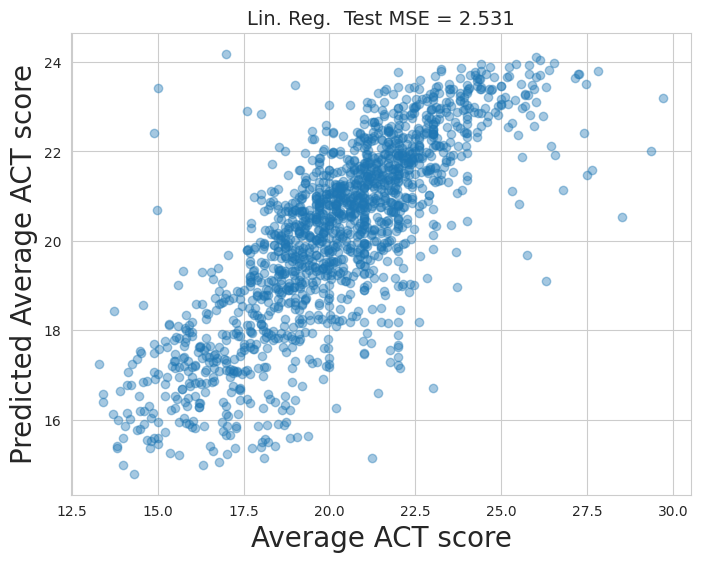

In [20]:
# Define the model
model_lr = LinearRegression()

# Fit the model
model_lr.fit(X_train, y_train)

# Compute test mean squared error
mse_lr = mean_squared_error(y_test, model_lr.predict(X_test))

# Print the coefficients
coef_sklearn = np.r_[model_lr.intercept_, model_lr.coef_]
print(coef_sklearn.round(3))

# Plot predictions
figure = plt.figure(figsize=(8, 6))

plt.plot(y_test, model_lr.predict(X_test), 'o', alpha = 0.4)
plt.xlabel('Average ACT score',fontsize = 20)
plt.title('Lin. Reg.' + ' ' + ' Test MSE = ' + str(mse_lr.round(3)),fontsize = 14)
plt.ylabel('Predicted Average ACT score',fontsize = 20);


## Using `scipy` and `numpy`

Note that the matrix `X` contains only the predictor variables and not the constant term.

In [21]:
X.head()

,median_income,percent_college,percent_lunch,percent_married,rate_unemployment
0,42820.0,0.445283,0.066901,0.346495,0.117962
1,89320.0,0.662765,0.112412,0.767619,0.063984
2,84140.0,0.701864,0.096816,0.713090,0.056460
3,56500.0,0.692062,0.296960,0.641283,0.044739
4,54015.0,0.640060,0.262641,0.834402,0.077014


To use `numpy` and `scipy` to fit the regression model, we need to form the complete design matrix with a column of `1's`

##### $\rightarrow$ Add a column of `1's` to the train and test matrices.

In [22]:
X_train_design = np.c_[np.ones(X_train.shape[0]), X_train]
X_test_design = np.c_[np.ones(X_train.shape[0]), X_train]

### Linear regression with `linalg.lstsq`

##### $\rightarrow$ Use `linalg.lstsq` to fit the regression line to the training data and compare the solution to the results found using `sklearn`.

In [23]:
coef, _,_,_ = linalg.lstsq(X_train_design, y_train)

Print the coefficients

In [24]:
coef

array([ 2.01834424e+01, -1.30993353e-02,  2.84652223e-01, -1.79917508e+00,
        1.27313299e-02, -1.44156285e-01])

Print the coefficients from `sklearn`

In [25]:
print(coef_sklearn)


[ 2.01834424e+01 -1.30993353e-02  2.84652223e-01 -1.79917508e+00
  1.27313299e-02 -1.44156285e-01]


Compute the mean absolute difference

In [26]:
mean_absolute_error(coef, coef_sklearn)

1.4146669946590862e-15

### Use the formula for the solution

We have seen that when the columns of $\mathbf{X}$ are linearly independent, the normal equations have the unique solution $$\hat{\boldsymbol{\beta}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}.$$

The straightforward way to compute the coefficients would be to compute the solution exactly as written in the formula.

##### $\rightarrow$ Check that the columns of $\mathbf{X}$ in the training data are linearly independent by computing the rank of the matrix, using `np.linalg.matrix_rank`, and comparing it to the number of columns.

In [27]:
r = np.linalg.matrix_rank(X_train_design)

num_col = X_train_design.shape[1]

print('The rank is ', r, ' and the number of columns is', num_col)

#checking to see if the columnns of X are linearly independent. Rank and col num equals

The rank is  6  and the number of columns is 6


##### $\rightarrow$ Use the transpose `.T` and inverse `linalg.inv` operations in `numpy` to fit the regression line to the training data and compare the solution to the results found using `sklearn`.

In [28]:
coef_formula = np.dot(linalg.inv(np.dot(X_train_design.T, X_train_design)), np.dot(X_train_design.T, y_train))

Print the coefficients

In [29]:
coef_formula

array([ 2.01834424e+01, -1.30993353e-02,  2.84652223e-01, -1.79917508e+00,
        1.27313299e-02, -1.44156285e-01])

Print the coefficients from `sklearn`

In [30]:
print(coef_sklearn)

[ 2.01834424e+01 -1.30993353e-02  2.84652223e-01 -1.79917508e+00
  1.27313299e-02 -1.44156285e-01]


Compute the mean absolute difference

In [31]:
mean_absolute_error(coef_formula, coef_sklearn)

8.757462347889581e-16

##### **Investigation**
Write a function called `lr_formula` that takes the design matrix $\mathbf{X}$ and observations $\mathbf{y}$ and returns the estimated coefficients in the regression line computed using the formula, as above. Check that it gives the same results you found above.

In [32]:
def lr_formula(X, y):
  coef_formula = np.dot(linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))
  return coef_formula

In [33]:
lr_formula(X_train_design, y_train)

array([ 2.01834424e+01, -1.30993353e-02,  2.84652223e-01, -1.79917508e+00,
        1.27313299e-02, -1.44156285e-01])

## Cholesky

Suppose that $\mathbf{X}^T\mathbf{X}$ has the Cholesky factorization $\mathbf{X}^T\mathbf{X} = \mathbf{L}\mathbf{L}^T$.

If $\mathbf{X}^T\mathbf{X} = \mathbf{L}\mathbf{L}^T$, then the normal equations look like $\mathbf{L}\mathbf{L}^T\boldsymbol{\beta}= \mathbf{X}^T\mathbf{y}$.

So, we can solve the triangular systems $\mathbf{L}\mathbf{z} = \mathbf{X}^T\mathbf{y}$ and $\mathbf{L}^T\boldsymbol{\beta} = \mathbf{z}$ to find $\boldsymbol{\beta}$.



##### $\rightarrow$ Use `linalg.cholesky` with option `lower = True` to fit the regression line to the training data and compare the solution to the results found using `sklearn`.

First compute the Cholesky factorization $\mathbf{X}^T\mathbf{X} = \mathbf{L}\mathbf{L}^T$.

In [34]:
L = linalg.cholesky(np.dot(X_train_design.T, X_train_design), lower=True)

Next solve the lower triangular system $\mathbf{L}\mathbf{z} = \mathbf{X}^T\mathbf{y}$ using `linalg.solve_triangular`

In [35]:
z = linalg.solve_triangular(L, np.dot(X_train_design.T, y_train), lower=True)

Finally, solve the upper triangular system $\mathbf{L}^T\boldsymbol{\beta} = \mathbf{z}$ to find $\boldsymbol{\beta}$.

In [36]:
coef_cholesky = linalg.solve_triangular(L.T, z, lower=False)

Print the coefficients

In [37]:
coef_cholesky

array([ 2.01834424e+01, -1.30993353e-02,  2.84652223e-01, -1.79917508e+00,
        1.27313299e-02, -1.44156285e-01])

Print the coefficients from `sklearn`

In [38]:
print(coef_sklearn)

[ 2.01834424e+01 -1.30993353e-02  2.84652223e-01 -1.79917508e+00
  1.27313299e-02 -1.44156285e-01]


Compute the mean absolute difference

In [39]:
mean_absolute_error(coef_cholesky, coef_sklearn)

7.441963711940502e-16

##### **Investigation**
Write a function called `lr_cholesky` that takes the design matrix $\mathbf{X}$ and observations $\mathbf{y}$ and returns the estimated coefficients in the regression line computed using the Cholesky factorization, as above. Check that it gives the same results you found above.

In [40]:
def lr_cholesky(X, y):
  L = linalg.cholesky(np.dot(X.T, X), lower = True)
  z = linalg.solve_triangular(L,np.dot(X.T, y), lower = True)
  coef_cholesky = linalg.solve_triangular(L.T, z, lower = False)
  return coef_cholesky

In [41]:
lr_cholesky(X_train_design, y_train)

array([ 2.01834424e+01, -1.30993353e-02,  2.84652223e-01, -1.79917508e+00,
        1.27313299e-02, -1.44156285e-01])

## QR

If $\mathbf{X} = \mathbf{Q}\mathbf{R}$ where $\mathbf{Q}$ is orthogonal, then the normal equations can be simplified to $\mathbf{R}\boldsymbol{\beta}= \mathbf{Q}^T\mathbf{y} $


##### $\rightarrow$ Use `linalg.qr` using the option `mode = 'economic'` to fit the regression line to the training data and compare the solution to the results found using `sklearn`.

First compute the $QR$ factorization

In [42]:
Q, R = linalg.qr(X_train_design, mode = 'economic')

Then solve the upper triangular system $\mathbf{R}\boldsymbol{\beta}= \mathbf{Q}^T\mathbf{y} $ to find $\boldsymbol{\beta}$.

In [43]:
coef_qr = linalg.solve_triangular(R, np.dot(Q.T, y_train), lower = False)

Print the coefficients

In [44]:
coef_qr

array([ 2.01834424e+01, -1.30993353e-02,  2.84652223e-01, -1.79917508e+00,
        1.27313299e-02, -1.44156285e-01])

Print the coefficients from `sklearn`

In [45]:
print(coef_sklearn)

[ 2.01834424e+01 -1.30993353e-02  2.84652223e-01 -1.79917508e+00
  1.27313299e-02 -1.44156285e-01]


Compute the mean absolute difference

In [46]:
mean_absolute_error(coef_qr, coef_sklearn)

1.284851854540155e-15

##### **Investigation**
Write a function called `lr_qr` that takes the design matrix $\mathbf{X}$ and observations $\mathbf{y}$ and returns the estimated coefficients in the regression line computed using the QR factorization, as above. Check that it gives the same results you found above.

In [47]:
def lr_qr(X, y):
  Q, R  = linalg.qr(X, mode = 'economic')
  coef_qr = linalg.solve_triangular(R, np.dot(Q.T, y), lower = False)
  return coef_qr

In [48]:
lr_qr(X_train_design,y_train)

array([ 2.01834424e+01, -1.30993353e-02,  2.84652223e-01, -1.79917508e+00,
        1.27313299e-02, -1.44156285e-01])

They look the same.

## SVD

If the design matrix $\mathbf{X}$ has full rank, and has the SVD $\mathbf{X} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T$, the solution to the normal equations is given by $$\hat{\boldsymbol{\beta}} =  \mathbf{X}^{\dagger}\mathbf{y} = \mathbf{V} \boldsymbol{\Sigma}^{\dagger}  \mathbf{U}^T \mathbf{y} = \mathbf{V}\boldsymbol{\Sigma}_{p+1}^{-1}\mathbf{U}_{1:p+1}^T\mathbf{y}.$$

This is equivalent to computing

$$\boldsymbol{\hat{\beta}}  = \mathbf{V}\mathbf{z}$$

where

$$ \boldsymbol{\Sigma}_{p+1} \mathbf{z} = \mathbf{U}_{1:p+1}^T\mathbf{y}$$


##### $\rightarrow$ Use `linalg.svd` using the option `full_matrices = False` to fit the regression line to the training data and compare the solution to the results found using `sklearn`.

First compute the SVD factorization

In [49]:
U, s, Vt = linalg.svd(X_train_design, full_matrices = False)

Note the sizes of each returned element:

In [50]:
print(X_train_design.shape, U.shape, s.shape, Vt.shape)

(6386, 6) (6386, 6) (6,) (6, 6)


Using `full_matrices = False` simplified the output by returning (1) only the singular values `s` and not the full matrix $\boldsymbol{\Sigma}$ and (2) the reduced $\mathbf{U}$ matrix $\mathbf{U}_{1:p+1}$.

Solving $ \boldsymbol{\Sigma}_{p+1} \mathbf{z} = \mathbf{U}_{1:p+1}^T\mathbf{y}$ is simple here because $\boldsymbol{\Sigma}_{p+1}$ is diagonal and $\mathbf{z} = \boldsymbol{\Sigma}_{p+1}^{-1}\mathbf{U}_{1:p+1}^T\mathbf{y}$ can be found by element-wise dividing the vector $\mathbf{U}_{1:p+1}^T\mathbf{y}$ by the vector of singular values.

In [51]:
z = np.dot(U.T, y_train)/s
#think about solving systems via cholesk and QR, passed in full matrix and asked to solve the whole system.
#know how to solve linear eqns, just needs the element wise division here

Then multiply by $\mathbf{V}$ to find the coefficients: $\hat{\boldsymbol{\beta}}  = \mathbf{V}\mathbf{z}$. Note that we were given $\mathbf{V}^T$, not $\mathbf{V}$.

In [52]:
coef_svd =np.dot(Vt.T, z)


Print the coefficients

In [53]:
coef_svd

array([ 2.01834424e+01, -1.30993353e-02,  2.84652223e-01, -1.79917508e+00,
        1.27313299e-02, -1.44156285e-01])

Print the coefficients from `sklearn`

In [54]:
print(coef_sklearn)

[ 2.01834424e+01 -1.30993353e-02  2.84652223e-01 -1.79917508e+00
  1.27313299e-02 -1.44156285e-01]


Compute the mean absolute difference

In [55]:
mean_absolute_error(coef_svd, coef_sklearn)

1.2596983641384914e-15

##### **Investigation**
Write a function called `lr_svd` that takes the design matrix $\mathbf{X}$ and observations $\mathbf{y}$ and returns the estimated coefficients in the regression line computed using the SVD, as above. Check that it gives the same results you found above.

In [56]:
def lr_svd(X, y):
  U,s, Vt = linalg.svd(X, full_matrices = False)
  z = np.dot(U.T, y)/s
  coef_svd = np.dot(Vt.T,z)
  return coef_svd


They look the same.

## Compare the methods

### Timing

##### $\rightarrow$ Use the magic function `%timeit` to time the computation of the regression coefficients using each function you defined above.

In [57]:
%timeit lr_formula(X_train_design, y_train)

1.33 ms ± 267 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [58]:
%timeit lr_cholesky(X_train_design, y_train)

1.24 ms ± 289 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [59]:
%timeit lr_qr(X_train_design, y_train)

The slowest run took 4.50 times longer than the fastest. This could mean that an intermediate result is being cached.
14 ms ± 6.57 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [60]:
%timeit lr_svd(X_train_design, y_train)

22.1 ms ± 6.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Comments

X_test_design = np.c_[np.ones(X_train.shape[0]), X_train] should use the test data:

X_test_design = np.c_[np.ones(X_test.shape[0]), X_test]


It is recommended that you use @ for matrix multiplication.

Discuss the timing of the methods at the end.